In [364]:
import numpy as np
import cv2

from feature_tracker import FeatureTrackerTypes, FeatureTracker, FeatureTrackingResult
from feature_orb2D import OrbFeature2D
from feature_matcher import feature_matcher_factory, FeatureMatcherTypes
from parameters import Parameters 
import random
import tracemalloc
import linecache
from visual_odometry import ImageRecievedState, VisualOdometry
from camera import KinectCamera
from utils import compute_euler_angle

In [365]:
import time

In [366]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [367]:
MinNumFeatureDefault = Parameters.MinNumFeatureDefault
RatioTest = Parameters.FeatureMatchRatioTest
gt_t = np.load("101/0/translations.npy")
gt_r = np.load("101/0/rotationsM.npy")
depth = np.load("101/0/depth.npy")

width  = 640
height = 480
fx     = 554.254691191187
fy     = 554.254691191187
cx     = 320.5
cy     = 240.5
D      = [0.0, 0.0, 0.0, 0.0, 0.0] 

cam = KinectCamera(width, height, fx, fy, cx, cy, D)

feature_tracker = FeatureTracker(num_features=MinNumFeatureDefault, 
                       num_levels = 8,  
                       scale_factor = 1.2,   
                       match_ratio_test = RatioTest, 
                       tracker_type = FeatureTrackerTypes.DES_BF)

Using Orb Feature 2D


In [393]:
vo = VisualOdometry(cam, feature_tracker, gt_t, gt_r)

In [394]:
#process first frame
max_n = 200
error_threshold = 0.2
path = "101/image_0.jpg"
img = cv2.imread(path)
vo.trackImage(img,0)

processing first frame


In [395]:
error = []
vo_est = []
cur_t = np.zeros((3,1))
cur_R = np.eye(3,3)
vo_est_gt = []
alpha = 0.3

for j in range(1,max_n):
    path = "101/image_"+str(j)+".jpg"
    img = cv2.imread(path)
    vo.trackImage(img,j)
    cv2.imwrite("test"+str(j)+".jpg", vo.draw_img)
    kps1 = vo.track_result.kps_ref_matched #x ,y 
    kps2=  vo.track_result.kps_cur_matched

    kps1_ = []
    for i in kps1:
        kps1_.append([i[1],i[0]])
    kps2_ = []
    for i in kps2:
        kps2_.append([i[1],i[0]])
    kps1_ = np.array(kps1_) #y, x
    kps2_ = np.array(kps2_)
    
    xyz1, idx1 = cam.unproject_points_z(kps1_, depth[j-1])
    xyz2, idx2 = cam.unproject_points_z(kps2_, depth[j])
    
    xyz1 = np.array(xyz1, np.float64)
    kps2_d = np.array(np.delete(kps2,idx1, axis=0),np.float32)
    
    _, r, t, inliers = cv2.solvePnPRansac( xyz1, kps2_d, cam.K, cam.D)
    
    vo_est.append((r,t))
    
    t = t[::-1]*-1
    cur_t = cur_t + t
    
    err = [a_i - b_i for a_i, b_i in zip(cur_t, gt_t[j])]
    error.append(err)
    err_sum = sum([abs(i) for i in err])
    if err_sum>error_threshold:
        alpha = alpha/(err_sum/error_threshold)
    pose = [e*alpha + t for e, t in zip(err, gt_t[j])]
    cur_t = pose
    vo_est_gt.append(pose)
    alpha = 0.3
    
    
    

processing 1 frame
# matched points:  1669 , # inliers:  1652
processing 2 frame
# matched points:  1694 , # inliers:  1682
processing 3 frame
# matched points:  1080 , # inliers:  885
processing 4 frame
# matched points:  979 , # inliers:  695
processing 5 frame
# matched points:  1018 , # inliers:  785
processing 6 frame
# matched points:  967 , # inliers:  619
processing 7 frame
# matched points:  857 , # inliers:  472
processing 8 frame
# matched points:  861 , # inliers:  473
processing 9 frame
# matched points:  865 , # inliers:  495
processing 10 frame
# matched points:  984 , # inliers:  732
processing 11 frame
# matched points:  954 , # inliers:  644
processing 12 frame
# matched points:  1005 , # inliers:  733
processing 13 frame
# matched points:  954 , # inliers:  643
processing 14 frame
# matched points:  956 , # inliers:  634
processing 15 frame
# matched points:  994 , # inliers:  701
processing 16 frame
# matched points:  945 , # inliers:  631
processing 17 frame
# matc

# matched points:  379 , # inliers:  124
processing 136 frame
# matched points:  402 , # inliers:  140
processing 137 frame
# matched points:  395 , # inliers:  135
processing 138 frame
# matched points:  419 , # inliers:  138
processing 139 frame
# matched points:  417 , # inliers:  126
processing 140 frame
# matched points:  369 , # inliers:  127
processing 141 frame
# matched points:  384 , # inliers:  124
processing 142 frame
# matched points:  406 , # inliers:  137
processing 143 frame
# matched points:  405 , # inliers:  126
processing 144 frame
# matched points:  379 , # inliers:  130
processing 145 frame
# matched points:  400 , # inliers:  136
processing 146 frame
# matched points:  364 , # inliers:  109
processing 147 frame
# matched points:  417 , # inliers:  144
processing 148 frame
# matched points:  380 , # inliers:  120
processing 149 frame
# matched points:  402 , # inliers:  159
processing 150 frame
# matched points:  352 , # inliers:  105
processing 151 frame
# matche

In [396]:
gt_t[max_n-1]

array([-1.324, -0.656,  0.   ])

In [397]:
vo_est_gt[-1]

[array([-1.29675129]), array([-0.65603535]), array([-0.00515232])]

In [378]:
eee

2.4801340800000005

In [398]:
x = []
z = []

x_mo = []
z_mo = []

for i in vo_est_gt:
    x.append(i[1])
    z.append(i[0])

for j in gt_t[:max_n]:
    x_mo.append(j[1])
    z_mo.append(j[0])

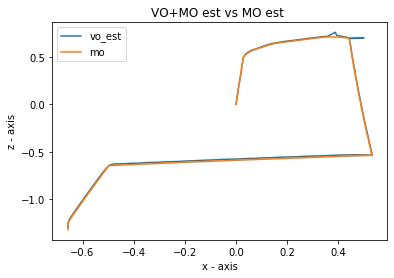

In [399]:
plt.plot(x,z,label="vo_est")
plt.plot(x_mo,z_mo,label="mo")
plt.title('VO+MO est vs MO est ')
plt.xlabel('x - axis')
plt.ylabel('z - axis')
plt.legend()
plt.show()

In [345]:
path = "101/image_57.jpg"
img = cv2.imread(path)
vo.trackImage(img,2)

processing first frame


In [355]:
path = "101/image_58.jpg"
img = cv2.imread(path)
vo.trackImage(img,2)

processing 2 frame
# matched points:  224 , # inliers:  86


In [356]:
cv2.imwrite("test3.jpg", vo.draw_img)

True

In [357]:
kps1 = vo.track_result.kps_ref_matched #x ,y 
kps2=  vo.track_result.kps_cur_matched

kps1_ = []
for i in kps1:
    kps1_.append([i[1],i[0]])
kps2_ = []
for i in kps2:
    kps2_.append([i[1],i[0]])
kps1_ = np.array(kps1_) #y, x
kps2_ = np.array(kps2_)

In [358]:
xyz1, idx1 = cam.unproject_points_z(kps1_, depth[57])
xyz2, idx2 = cam.unproject_points_z(kps2_, depth[58])

In [359]:
x=[]
y=[]
z=[]
for a in vo_est_gt:
    z.append(a[0])
    x.append(a[1])
    y.append(a[2])

In [360]:
xyz1 = np.array(xyz1, np.float64)

In [361]:
kps2_d = np.array(np.delete(kps2,idx1, axis=0),np.float32)

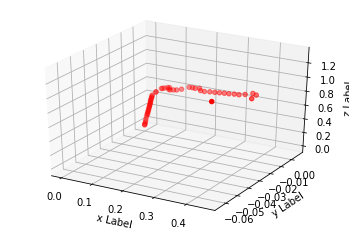

In [340]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('x Label')
ax.set_ylabel('y Label')
ax.set_zlabel('z Label')

plt.show()

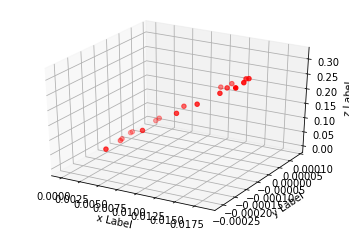

In [270]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('x Label')
ax.set_ylabel('y Label')
ax.set_zlabel('z Label')

plt.show()

In [341]:
x=[]
y=[]
z=[]
for a in xyz2:
    x.append(a[0])
    y.append(a[1])
    z.append(a[2])

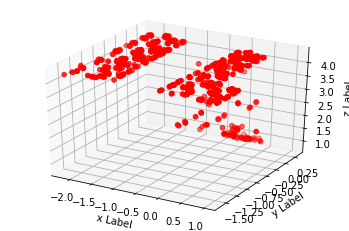

In [135]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('x Label')
ax.set_ylabel('y Label')
ax.set_zlabel('z Label')

plt.show()

In [362]:
_, r, t, i = cv2.solvePnPRansac( xyz1, kps2_d, cam.K, cam.D)

In [363]:
t

array([[ 0.2164832 ],
       [-0.26433402],
       [-2.02037737]])

In [214]:
t5 = t5+np.zeros((3,1))

In [189]:
gt_t[6]

array([0.064, 0.004, 0.   ])

In [208]:
t5[::-1]*-1

array([[ 5.99125972e-02],
       [ 1.88985754e-04],
       [-8.95915196e-05]])

In [209]:
err= [a_i - b_i for a_i, b_i in zip(t5[::-1]*-1, gt_t[6])]

In [210]:
err

[array([-0.0040874]), array([-0.00381101]), array([-8.95915196e-05])]

In [200]:
gt_t[6]

array([0.064, 0.004, 0.   ])

In [211]:
gt6 =[a_i*0.3 + b_i for a_i, b_i in zip(err, gt6)]

In [212]:
gt6

[array([0.06277378]), array([0.0028567]), array([-2.68774559e-05])]

In [19]:
im = vo.draw_img

In [20]:
cv2.imwrite("ii.jpg",im)

True

In [110]:
path = "101/image_2.jpg"
img = cv2.imread(path)
vo.trackImage(img,2)

processing 2 frame
# matched points:  505 , # inliers:  493


In [149]:
for i in range(5):
    path = "101/image_"+str(i)+".jpg"
    img = cv2.imread(path)
    vo.trackImage(img,i)

processing first frame
processing 1 frame
# matched points:  538 , # inliers:  530
processing 2 frame
# matched points:  505 , # inliers:  493
processing 3 frame
# matched points:  469 , # inliers:  453
processing 4 frame
# matched points:  516 , # inliers:  504


In [88]:
p=vo.trans_est_ref

In [90]:
p=np.round(np.reshape(p, (66,3)),2)

In [91]:
p=p/10

In [5]:

start = time.time()
for i in range(300):
    print(i)
    path = "101/image_"+str(i)+".jpg"
    img = cv2.imread(path)
    if img is not None:
        vo.trackImage(img, i)
    else: print("image is not read")
end = time.time()

print("time elapsed: ", end-start)
    

0
processing first frame
1
processing 1 frame
# matched points:  538 , # inliers:  530
2
processing 2 frame
# matched points:  505 , # inliers:  493
3
processing 3 frame
# matched points:  469 , # inliers:  453
4
processing 4 frame
# matched points:  516 , # inliers:  504
5
processing 5 frame
# matched points:  509 , # inliers:  493
6
processing 6 frame
# matched points:  495 , # inliers:  476
7
processing 7 frame
# matched points:  277 , # inliers:  215
8
processing 8 frame
# matched points:  308 , # inliers:  224
9
processing 9 frame
# matched points:  297 , # inliers:  193
10
processing 10 frame
# matched points:  347 , # inliers:  286
11
processing 11 frame
# matched points:  316 , # inliers:  242
12
processing 12 frame
# matched points:  271 , # inliers:  194
13
processing 13 frame
# matched points:  322 , # inliers:  251
14
processing 14 frame
# matched points:  312 , # inliers:  240
15
processing 15 frame
# matched points:  307 , # inliers:  226
16
processing 16 frame
# matched 

# matched points:  629 , # inliers:  191
129
processing 129 frame
# matched points:  781 , # inliers:  272
130
processing 130 frame
# matched points:  1041 , # inliers:  828
131
processing 131 frame
# matched points:  975 , # inliers:  466
132
processing 132 frame
# matched points:  999 , # inliers:  640
133
processing 133 frame
# matched points:  996 , # inliers:  678
134
processing 134 frame
# matched points:  1016 , # inliers:  688
135
processing 135 frame
# matched points:  1003 , # inliers:  673
136
processing 136 frame
# matched points:  1022 , # inliers:  711
137
processing 137 frame
# matched points:  1052 , # inliers:  750
138
processing 138 frame
# matched points:  1016 , # inliers:  633
139
processing 139 frame
# matched points:  1041 , # inliers:  732
140
processing 140 frame
# matched points:  1017 , # inliers:  663
141
processing 141 frame
# matched points:  1022 , # inliers:  656
142
processing 142 frame
# matched points:  1001 , # inliers:  697
143
processing 143 frame


# matched points:  457 , # inliers:  351
253
processing 253 frame
# matched points:  443 , # inliers:  348
254
processing 254 frame
# matched points:  432 , # inliers:  315
255
processing 255 frame
# matched points:  446 , # inliers:  346
256
processing 256 frame
# matched points:  456 , # inliers:  344
257
processing 257 frame
# matched points:  444 , # inliers:  316
258
processing 258 frame
# matched points:  445 , # inliers:  331
259
processing 259 frame
# matched points:  438 , # inliers:  327
260
processing 260 frame
# matched points:  424 , # inliers:  317
261
processing 261 frame
# matched points:  407 , # inliers:  297
262
processing 262 frame
# matched points:  408 , # inliers:  300
263
processing 263 frame
# matched points:  407 , # inliers:  304
264
processing 264 frame
# matched points:  411 , # inliers:  319
265
processing 265 frame
# matched points:  377 , # inliers:  250
266
processing 266 frame
# matched points:  410 , # inliers:  340
267
processing 267 frame
# matched 

In [53]:
p = vo.trans_est_ref2

In [30]:
t_xzy = []

for i in range(len(t)):
    t_xzy.append([t[i][0],t[i][2],t[i][1]])

In [51]:
t[:280]

array([[ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ],
       [ 0.019, -0.003,  0.   ],
       [ 0.039, -0.007,  0.   ],
       [ 0.06 , -0.01 ,  0.   ],
       [ 0.077, -0.013,  0.   ],
       [ 0.101, -0.017,  0.   ],
       [ 0.119, -0.02 ,  0.   ],
       [ 0.136, -0.023,  0.   ],
       [ 0.156, -0.026,  0.   ],
       [ 0.178, -0.03 ,  0.   ],
       [ 0.198, -0.034,  0.   ],
       [ 0.217, -0.037,  0.   ],
       [ 0.238, -0.041,  0.   ],
       [ 0.257, -0.044,  0.   ],
       [ 0.277, -0.047,  0.   ],
       [ 0.296, -0.051,  0.   ],
       [ 0.316, -0.054,  0.   ],
       [ 0.337, -0.058,  0.   ],
       [ 0.358, -0.062,  0.   ],
       [ 0.374, -0.065,  0.   ],
       [ 0.396, -0.069,  0.   ],
       [ 0.411, -0.071,  0.   ],
       [ 0.437, -0.076,  0.   ],
       [ 0.456, -0.079,  0.   ],
       [ 0

In [ ]:
t_xzy = np.round(t_xzy,2)
t_xzy[:54]

In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [272]:
x = []
z = []

for i in gt_t[:20]:
    x.append(i[1])
    z.append(i[0])
    

In [ ]:
xn = []
yn = []

for i in range(200):
    xn.append(((p[i][0])+(t[i][0]))/2)
    yn.append(((p[i][1])+(t[i][1]))/2)
    

In [93]:
x_t = []
y_t = []

for i in range(66):
    x_t.append(t[i][0])
    y_t.append(t[i][1])

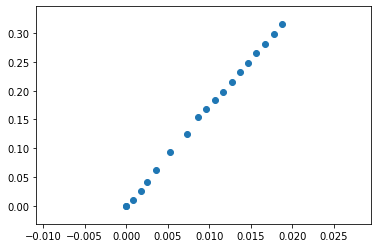

In [271]:
plt.scatter(x, z)
plt.show()

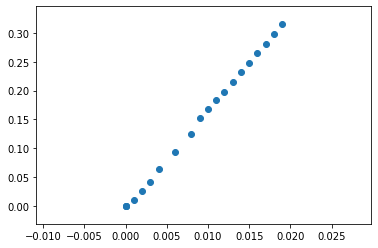

In [273]:
plt.scatter(x, z)
plt.show()

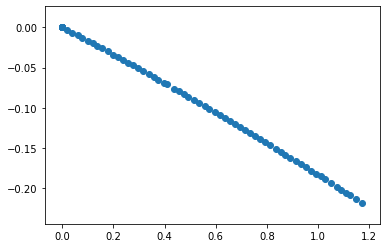

In [95]:
plt.scatter(x_t, y_t)
plt.show()

In [97]:
c = compute_euler_angle(vo.cur_R)

In [98]:
c

array([1.1353185 , 0.01137473, 2.94796369])

In [16]:
def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))


In [16]:
vo.trans_est

array([[ 0.78281471],
       [-0.0212825 ],
       [ 0.62189081]])

In [15]:
cv2.imwrite("Images/current.jpg", img2)

True

In [17]:
print(vo.cur_R)

[[ 0.99959432  0.00204117  0.02840809]
 [-0.00209109  0.99999632  0.00172741]
 [-0.02840446 -0.00178611  0.99959492]]


In [11]:
print(vo.cur_t)

[[ 0.78281471]
 [-0.0212825 ]
 [ 0.62189081]]


In [64]:
a,b = None, None

In [21]:
vo.trans_est_ref

[[array([0.]), array([0.]), array([0.])]]

In [32]:
compute_euler_angle(vo.cur_R)

array([-0.00492516,  0.0938872 , -0.01327321])

In [12]:
vo.trackImage(image_2)

processing second frame
# matched points:  55 , # inliers:  19


In [13]:
img2 = vo.draw_img
cv2.imwrite("Images/res/image2.jpg", img2)

True

In [16]:
vo.cur_t

array([[1.18445052],
       [0.05603373],
       [1.53442075]])

In [19]:
vo.poses[0]

array([[ 0.99959432,  0.00204117,  0.02840809,  0.        ],
       [-0.00209109,  0.99999632,  0.00172741,  0.        ],
       [-0.02840446, -0.00178611,  0.99959492,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [20]:
vo.poses[1]

array([[ 9.98023904e-01, -3.12445700e-04,  6.28346193e-02,
         4.01635806e-01],
       [ 9.73925527e-04,  9.99944431e-01, -1.04969621e-02,
         7.73162345e-02],
       [-6.28278480e-02,  1.05374154e-02,  9.97968749e-01,
         9.12529933e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [26]:
vo.trans_est_ref

[[array([0.]), array([0.]), array([0.])],
 [array([0.40163581]), array([0.07731623]), array([0.91252993])]]

In [22]:
vo.cur_t

array([[1.18445052],
       [0.05603373],
       [1.53442075]])

In [23]:
vo.cur_R

array([[ 9.98023904e-01, -3.12445700e-04,  6.28346193e-02],
       [ 9.73925527e-04,  9.99944431e-01, -1.04969621e-02],
       [-6.28278480e-02,  1.05374154e-02,  9.97968749e-01]])

In [27]:
vo.trackImage(image_3)

processing second frame
# matched points:  50 , # inliers:  15


In [28]:
img2 = vo.draw_img
cv2.imwrite("Images/res/image2.jpg", img2)

True

In [29]:
vo.trans_est_ref

[[array([0.]), array([0.]), array([0.])],
 [array([0.40163581]), array([0.07731623]), array([0.91252993])],
 [array([0.95375506]), array([-0.00526277]), array([1.74219555])]]

In [30]:
vo.cur_t

array([[ 1.73656977],
       [-0.02654527],
       [ 2.36408636]])

In [31]:
vo.cur_R

array([[ 0.99550813,  0.01321437,  0.09374933],
       [-0.01373435,  0.99989366,  0.00490345],
       [-0.09367457, -0.00616901,  0.99558376]])

In [34]:
img3 = vo.draw_img
cv2.imwrite("Images/res/image3.jpg", img3)

True

In [65]:
r

array([[-0.   , -0.   , -1.678],
       [-0.   , -0.   , -1.679],
       [-0.   , -0.   , -1.68 ],
       [-0.   , -0.   , -1.681],
       [-0.   , -0.   , -1.682],
       [-0.   , -0.   , -1.68 ],
       [-0.   , -0.   , -1.677],
       [-0.   , -0.   , -1.679],
       [-0.   , -0.   , -1.681],
       [-0.   , -0.   , -1.681],
       [-0.   , -0.   , -1.681],
       [-0.   , -0.   , -1.683],
       [-0.   , -0.   , -1.685],
       [-0.   , -0.   , -1.687],
       [-0.   , -0.   , -1.689],
       [-0.   , -0.   , -1.691],
       [-0.   , -0.   , -1.694],
       [-0.   , -0.   , -1.695],
       [-0.   , -0.   , -1.696],
       [-0.   , -0.   , -1.651],
       [-0.   , -0.   , -1.466],
       [-0.   , -0.   , -1.304],
       [-0.   , -0.   , -1.136],
       [-0.   , -0.   , -0.961],
       [-0.   , -0.   , -0.806],
       [-0.   , -0.   , -0.634],
       [-0.   , -0.   , -0.472],
       [-0.   , -0.   , -0.31 ],
       [-0.   , -0.   , -0.182],
       [ 0.   , -0.   ,  0.018],
       [ 0